### Imports

In [1]:
import glob
import h5py
import numpy as np
import os
import PIL

from layers import BilinearUpSampling2D
from loss import depth_loss_function
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from utils import predict

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (

In [2]:
# Globals
MODEL = 'nyu.h5'
DATASET = 'nyu_depth_v2_labeled.mat'

### Load Model

In [3]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

# Load model into GPU / CPU
print('Loading model...')
model = load_model(MODEL, custom_objects=custom_objects, compile=False)
print(f'\nModel loaded ({MODEL}).')

Loading model...
Instructions for updating:
Colocations handled automatically by placer.

Model loaded (nyu.h5).


### Helper Functions

In [4]:
def display_depth(image, title='', axis=False, color_map='plasma'):
    """
    Display depth image as a heatmap.
    """
    plt.figure(figsize=(10,5))
    out = plt.imshow(image, cmap=color_map, interpolation='nearest')
    out = plt.colorbar()
    plt.title(title)
    if not axis:
        plt.axis('off')

def display_rgb(image, title='', axis=False):
    """
    Display regular RGB image.
    """
    plt.figure(figsize=(10,5))
    out = plt.imshow(image)
    plt.title(title)
    if not axis:
        plt.axis('off')

In [5]:
def condense_image(image_src):
    """
    Delete every other row and column of the image array so it matched dimensions
    of our predicted images.
    """
    image = np.copy(image_src)
    for row in reversed(range(len(image))):
        if row % 2 != 0:
            image = np.delete(image, row, 0)

    for column in reversed(range(len(image[0]))):
        if column % 2 != 0:
            image = np.delete(image, column, 1)
    return image

def normalize_image(image):
    """
    Normalizes depth map image to be between 0 and 1.
    """
    min = np.min(image)
    max = np.max(image)
    return (image - min) / (max - min)

In [6]:
def load_images_with_resize(image_files):
    """
    Loads image files from disk.
    """
    loaded_images = []
    for file in image_files:
        im = Image.open( file )
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def get_ground_truth(index: int):
    """
    Gets single ground truth image from dataset.
    """
    f = h5py.File(DATASET, 'r')
    nyu_depth_image = f['depths'][index]

    return condense_image(nyu_depth_image.T)

def get_ground_truth_images(indices: list):
    """
    Gets ground truth images from dataset using list of indicies.
    """
    ground_truth_images = []
    f = h5py.File(DATASET, 'r')
    for i in indices:
        ground_truth_images.append(condense_image(f['depths'][i].T))
    return ground_truth_images

def get_relative(index: int):
    """
    Grabs jpeg images from /training_images and creates relative depth maps of
    them. Returns array of depth maps.
    """
    f = h5py.File(DATASET, 'r')
    inputs = []

    im = f['images'][index].T
    x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
    inputs.append(x)
    inputs = np.stack(inputs, axis=0)
    outputs = predict(model, inputs)
    
    return normalize_image(np.asarray(outputs[0]))

def get_relative_images(indices: list):
    """
    Creates relative depth maps from database given a list of indices. Returns
    array of depth maps.
    """
    f = h5py.File(DATASET, 'r')
    predicted_images = []
    inputs = []

    for i in indices:
        im = f['images'][i].T
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        inputs.append(x)
    inputs = np.stack(inputs, axis=0)
    outputs = predict(model, inputs)
    
    for i in range(len(outputs)):
        predicted_images.append(normalize_image(np.asarray(outputs[i])))
    return predicted_images

def get_rgb(index: int):
    """
    Returns single RGB image from dataset.
    """
    f = h5py.File(DATASET, 'r')         
    return f['images'][index].T       

def get_rgb_images(indices: list):
    """
    Returns list of RGB images from dataset.
    """
    rgb_images = []
    f = h5py.File(DATASET, 'r')
    for i in indices:
        rgb_images.append(condense_image(f['images'][i]))
    return rgb_images

def get_similar_images(index: int):
    """
    Gets a list of images with similar closest and furthest distances. Does not
    include the parameter index.
    """
    f = h5py.File(DATASET, 'r')
    source_img_max = f['depths'][index].max()
    source_img_min = f['depths'][index].min()
    nyu_images = []
    for i in range(len(f['depths'])):
        if (source_img_min - 0.1 <= f['depths'][i].min() <= source_img_min + 0.1
            and source_img_max - 0.1 <= f['depths'][i].max() <= source_img_max + 0.1
            and i != index):
            nyu_images.append(i)
    return nyu_images

## Proof of Concept

### Predict/Display Relative and True Depth Image

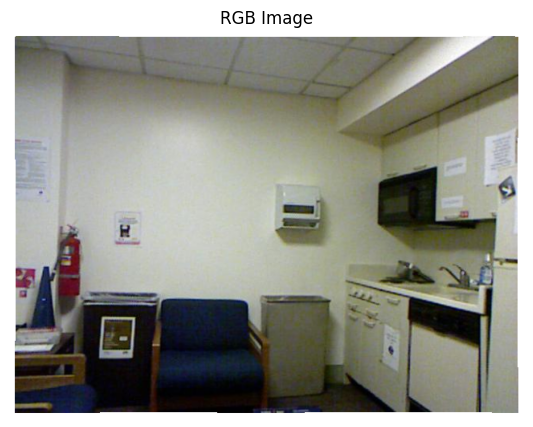

In [7]:
# Normal Image
rgb_image = get_rgb(0)
display_rgb(rgb_image, "RGB Image")

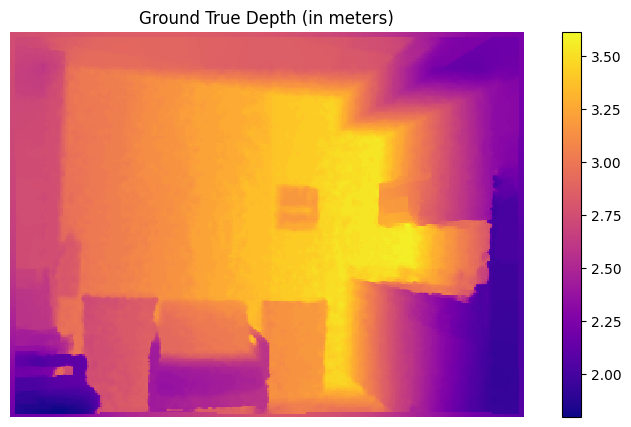

In [8]:
# Display Ground-Truth Image
true_depth_image = get_ground_truth(0)
display_depth(true_depth_image, "Ground True Depth (in meters)")

In [9]:
# Input images
inputs = load_images_with_resize(glob.glob('training_images/*.jpg'))

# Compute predicted heatmap
print("Predicting...")
outputs = predict(model, inputs)
print("\nPredicted")

c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


Predicting...

Predicted


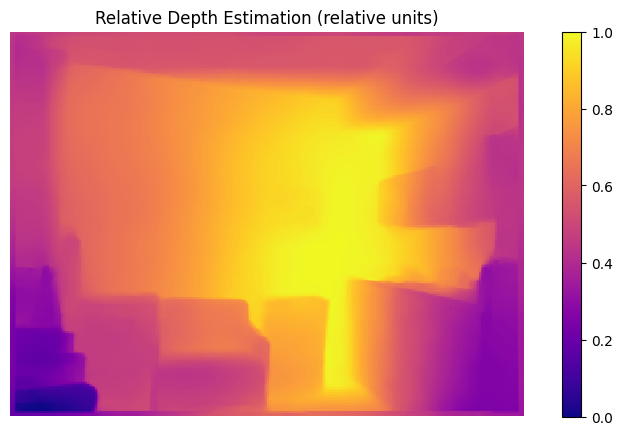

In [10]:
# Display Relative Predicted Image
predicted_image = normalize_image(np.asarray(outputs[0]))
display_depth(predicted_image, "Relative Depth Estimation (relative units)")

### Calculate Function Between Relative and True Depth For A Single Image

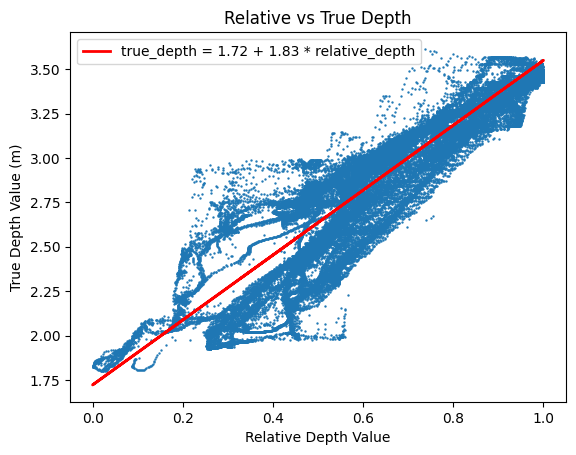

In [11]:
# Display the two images as a function between each other
x_axis = predicted_image.flatten()
y_axis = true_depth_image.flatten()

# Create linear best fit line
a, b = np.polyfit(x_axis, y_axis, 1)

# Plot the scatter plot and best fit
plt.scatter(x_axis, y_axis, s=0.5)
plt.title('Relative vs True Depth')
plt.xlabel('Relative Depth Value')
plt.ylabel('True Depth Value (m)')
plt.plot(x_axis, a*x_axis + b, linewidth=2, color='red', label='true_depth = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * relative_depth')
out = plt.legend(loc='upper left')
plt.show()

### Apply Naive Equation to a Single Similar Image

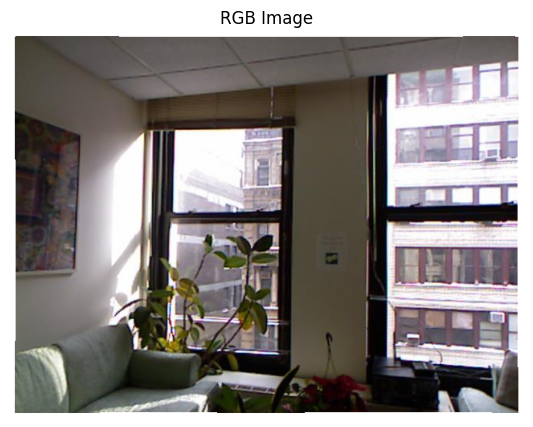

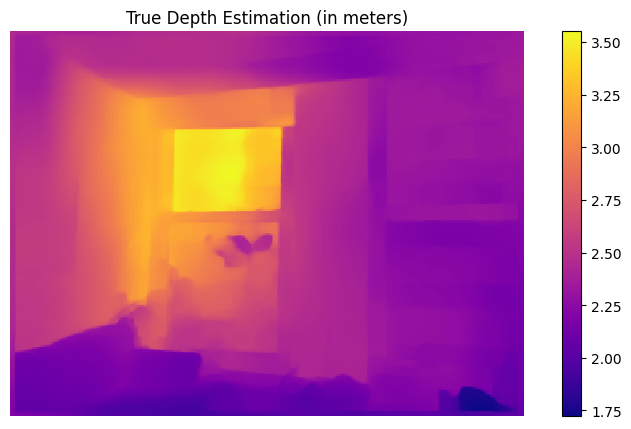

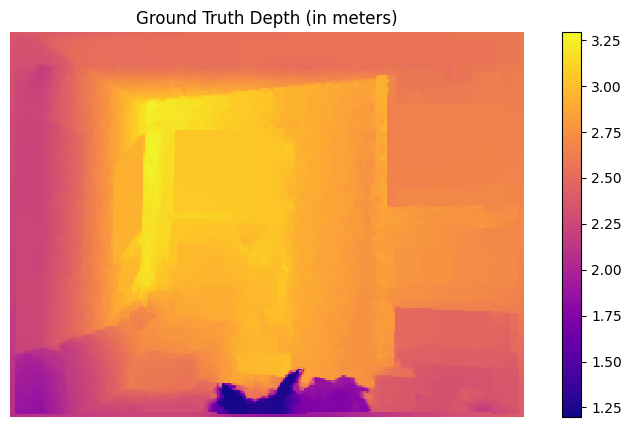

In [12]:
# Get Various Images
rgb_image = get_rgb(13)
ground_truth_image = get_ground_truth(13)
relative_depth_image = get_relative(13)

# Apply Equation to Image
estimated_true_depth_image = a * relative_depth_image + b

# Display Various Images
display_rgb(rgb_image, "RGB Image")
display_depth(estimated_true_depth_image, "True Depth Estimation (in meters)")
display_depth(ground_truth_image, "Ground Truth Depth (in meters)")

## More Realistic Application

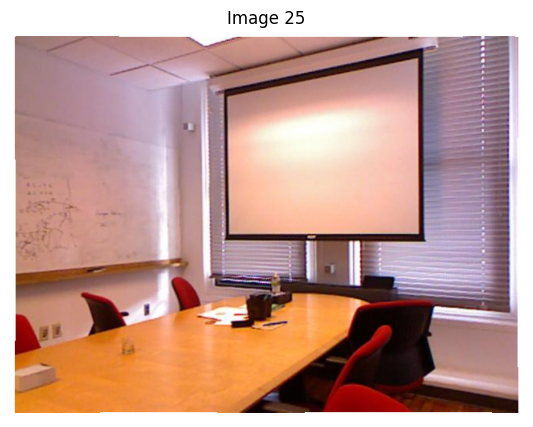

In [13]:
# ===== Image to Test ===== #
IMAGE_INDEX = 25
# ========================= #

display_rgb(get_rgb(IMAGE_INDEX), title=f"Image {IMAGE_INDEX}")

### Calculate Function Between Relative and True Depth For Multiple Images

In [14]:
# Images to train off of
image_indices = get_similar_images(IMAGE_INDEX)
print("Number of Similar Images:", len(image_indices))

assert len(image_indices) != 0, f"no matches for image [{IMAGE_INDEX}]"

Number of Similar Images: 8


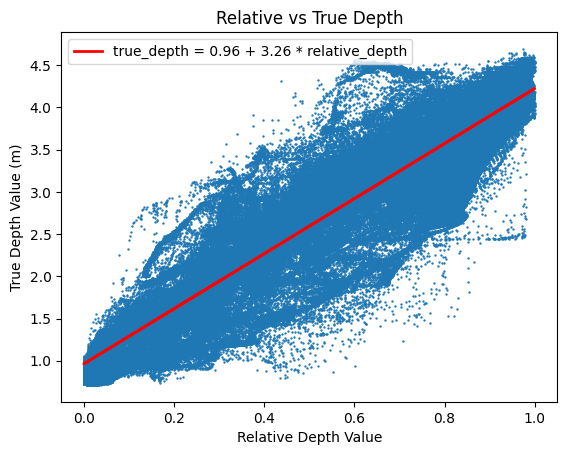

In [15]:
# Get relative and true depth images for the training set
true_depth_images = get_ground_truth_images(image_indices)
relative_depth_images = get_relative_images(image_indices)

x_axis = []
y_axis = []
for i in range(len(image_indices)):
    x_axis = np.concatenate((x_axis, relative_depth_images[i].flatten()), axis=None)
    y_axis = np.concatenate((y_axis, true_depth_images[i].flatten()), axis=None)

# Create linear best fit line between relative and true depth
a, b = np.polyfit(x_axis, y_axis, 1)

# Plot the scatter plot and best fit line
plt.scatter(x_axis, y_axis, s=0.5)
plt.title('Relative vs True Depth')
plt.xlabel('Relative Depth Value')
plt.ylabel('True Depth Value (m)')
plt.plot(x_axis, a*x_axis + b, linewidth=2, color='red', label='true_depth = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * relative_depth')
out = plt.legend(loc='upper left')
plt.show()

### Apply Equation to Reference Image

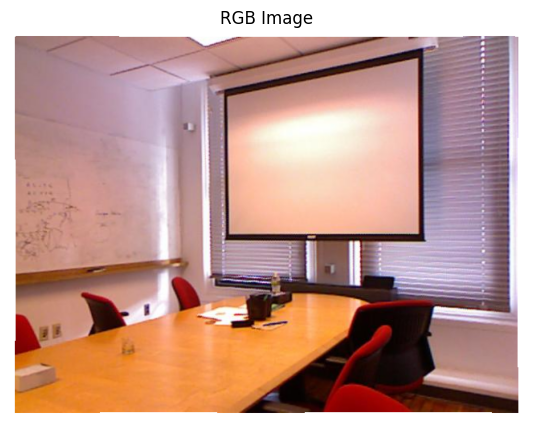

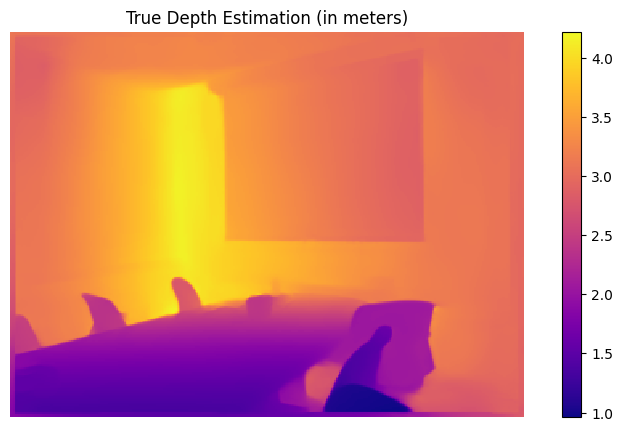

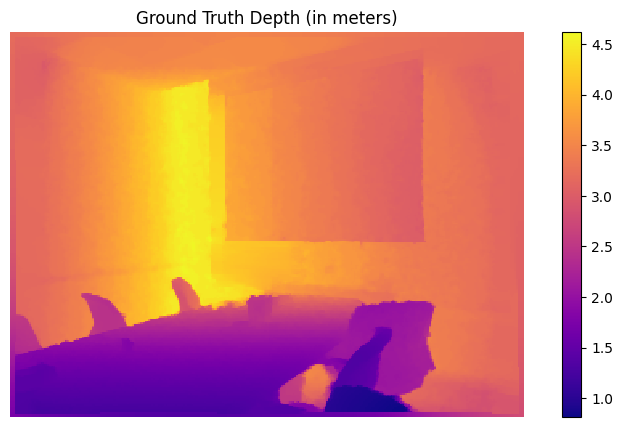

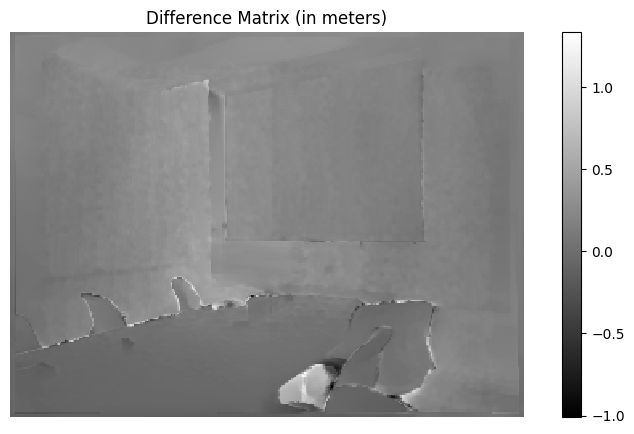

In [16]:
# Get Various Images
rgb_image = get_rgb(IMAGE_INDEX)
ground_truth_image = get_ground_truth(IMAGE_INDEX)
relative_depth_image = get_relative(IMAGE_INDEX)

# Apply Equation to Image
estimated_true_depth_image = a * relative_depth_image + b
estimated_true_depth_image = np.reshape(estimated_true_depth_image, (240, 320))

# Find difference matrix between ground truth and estimated depth
difference = ground_truth_image - estimated_true_depth_image

# Display Various Images
display_rgb(rgb_image, "RGB Image")
display_depth(estimated_true_depth_image, "True Depth Estimation (in meters)")
display_depth(ground_truth_image, "Ground Truth Depth (in meters)")
display_depth(difference, title="Difference Matrix (in meters)", color_map="gray")